<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://docs.unidata.ucar.edu/images/logos/unidata_logo_vertical_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

# Forecast Model Vertical Sounding
**Python-AWIPS Tutorial Notebook**

<div style="clear:both"></div>
</div>

---

<div style="float:right; width:250 px"><img src="../images/forecast_model_vert_sounding_preview.png" alt="preview image of a model sounding skewt and hodograph" style="height: 300px;"></div>


# Objectives

* Use python-awips to connect to an edex server
* Request data using the [ModelSounding class](http://unidata.github.io/python-awips/api/ModelSounding.html) in addition to using the normal [DataAccess class](http://unidata.github.io/python-awips/api/DataAccessLayer.html)
* Create and compare vertical sounding from different AWIPS model data with isobaric levels
* Use [Shapely Point geometry](https://shapely.readthedocs.io/en/stable/reference/shapely.Point.html) to define a point
* Convert between units when necessary
* Use MetPy to create [SkewT](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.SkewT.html) and [Hodograph](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.Hodograph.html) plots

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#EDEX-Connection" data-toc-modified-id="EDEX-Connection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDEX Connection</a></span></li><li><span><a href="#Define-Useful-Variables" data-toc-modified-id="Define-Useful-Variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define Useful Variables</a></span></li><li><span><a href="#Function:-get_surface_data()" data-toc-modified-id="Function:-get_surface_data()-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Function: get_surface_data()</a></span></li><li><span><a href="#Function:-get_levels_data()" data-toc-modified-id="Function:-get_levels_data()-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Function: get_levels_data()</a></span></li><li><span><a href="#Function:-plot_skewT()" data-toc-modified-id="Function:-plot_skewT()-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Function: plot_skewT()</a></span></li><li><span><a href="#Retrieve-Necessary-Plotting-Data" data-toc-modified-id="Retrieve-Necessary-Plotting-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Retrieve Necessary Plotting Data</a></span></li><li><span><a href="#Skew-T/Log-P" data-toc-modified-id="Skew-T/Log-P-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Skew-T/Log-P</a></span></li><li><span><a href="#Model-Sounding-Comparison" data-toc-modified-id="Model-Sounding-Comparison-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model Sounding Comparison</a></span></li><li><span><a href="#See-Also" data-toc-modified-id="See-Also-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>See Also</a></span><ul class="toc-item"><li><span><a href="#Related-Notebooks" data-toc-modified-id="Related-Notebooks-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Related Notebooks</a></span></li><li><span><a href="#Additional-Documentation" data-toc-modified-id="Additional-Documentation-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Additional Documentation</a></span></li></ul></li></ul></div>

## Imports

The imports below are used throughout the notebook.  Note the first import is coming directly from python-awips and allows us to connect to an EDEX server.  The subsequent imports are for data manipulation and visualization. 

In [1]:
from awips.dataaccess import DataAccessLayer, ModelSounding
import matplotlib.pyplot as plt
import numpy as np
from metpy.plots import SkewT, Hodograph
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import Point

<a href="#top">Top</a>

---

## EDEX Connection

First we establish a connection to Unidata's public EDEX server. This sets the proper server on the **DataAccessLayer**, which we will use numerous times throughout the notebook.

In [2]:
server = 'edex-cloud.unidata.ucar.edu'
DataAccessLayer.changeEDEXHost(server)

<a href="#top">Top</a>

---

## Define Useful Variables

The plotting in this notebook needs a model name, a location point (defined by latitude and longitude), and the most recent time range with the initial forecast run.

In [3]:
# Note the order is Lon,Lat and not Lat,Lon
point = Point(-104.67,39.87)
model="NAM40"

# Get latest forecast cycle run
timeReq = DataAccessLayer.newDataRequest("grid")
timeReq.setLocationNames(model)
cycles = DataAccessLayer.getAvailableTimes(timeReq, True)
times = DataAccessLayer.getAvailableTimes(timeReq)
fcstRun = DataAccessLayer.getForecastRun(cycles[-2], times)

timeRange = [fcstRun[0]]

print("Using " + model + " forecast time " + str(timeRange))

Using NAM40 forecast time [<DataTime instance: 2026-01-24 18:00:00 (0) >]


<a href="#top">Top</a>

---

## Function: get_surface_data()

This function is used to get the initial forecast model data for surface height.  This is done separately from the rest of the heights to determine the surface pressure.  It uses the [**ModelSounding**](http://unidata.github.io/python-awips/api/ModelSounding.html) data object from python-awips to retrieve all the relevant information.

This function takes the model name, location, and time as attributes, and returns arrays for pressure, temperature, dewpoint, and the u and v wind components.

In [4]:
def get_surface_data(modelName, location, time):
    """ model name, location, and timeRange desire """
    
    # request data and sort response
    pressure,temp,dpt,ucomp,vcomp = [],[],[],[],[]
    use_parms = ['T','DpT','uW','vW','P']
    use_level = "0.0FHAG"
    
    sndObject = ModelSounding.getSounding(modelName, use_parms, [use_level], location, time)
    if len(sndObject) > 0:
        for time in sndObject._dataDict:
            pressure.append(float(sndObject._dataDict[time][use_level]['P']))
            temp.append(float(sndObject._dataDict[time][use_level]['T']))
            dpt.append(float(sndObject._dataDict[time][use_level]['DpT']))
            ucomp.append(float(sndObject._dataDict[time][use_level]['uW']))
            vcomp.append(float(sndObject._dataDict[time][use_level]['vW']))
        print("Found surface record at " + "%.1f" % pressure[0] + "MB")
    else:
        raise ValueError("sndObject returned empty for query [" 
                        + ', '.join(str(x) for x in (modelName, use_parms, point, use_level)) +"]")

    # return information for plotting
    return pressure,temp,dpt,ucomp,vcomp

<a href="#top">Top</a>

---

## Function: get_levels_data()

This function is similar to *get_surface_data()*, except it gets data values for presure heights above the surface.  It uses the [**ModelSounding**](http://unidata.github.io/python-awips/api/ModelSounding.html) data object from python-awips to retrieve all the relevant information.

It takes the model name, location, and time (similar to the other function), and also takes the instantiated pressure, temperature, dewpoint, and wind vector arrays.

It returns the fully populated pressure, temperature, dewpoint, u-component, v-component, and computed wind arrays.

In [5]:
def get_levels_data(modelName, location, time, pressure, temp, dpt, ucomp, vcomp):
    
    # Get isobaric levels with our requested parameters
    parms = ['T','DpT','uW','vW']
    levelReq = DataAccessLayer.newDataRequest("grid", envelope=point)
    levelReq.setLocationNames(model)
    levelReq.setParameters(*(parms))
    availableLevels = DataAccessLayer.getAvailableLevels(levelReq)
    
    # Clean levels list of unit string (MB, FHAG, etc.)
    levels = []
    for lvl in availableLevels:
        name=str(lvl)
        if 'MB' in name and '_' not in name:
            # If this level is above (less than in mb) our 0.0FHAG record
            if float(name.replace('MB','')) < pressure[0]:
                levels.append(lvl)

    # Get Sounding
    sndObject = ModelSounding.getSounding(modelName, parms, levels, location, time)

    if not len(sndObject) > 0:
        raise ValueError("sndObject returned empty for query [" 
                        + ', '.join(str(x) for x in (model, parms, point, levels)) +"]")

    for time in sndObject._dataDict:
        for lvl in sndObject._dataDict[time].levels():
            for parm in sndObject._dataDict[time][lvl].parameters():
                if parm == "T":
                    temp.append(float(sndObject._dataDict[time][lvl][parm]))
                elif parm == "DpT":
                    dpt.append(float(sndObject._dataDict[time][lvl][parm]))
                elif parm == 'uW':
                    ucomp.append(float(sndObject._dataDict[time][lvl][parm]))
                elif parm == 'vW':
                    vcomp.append(float(sndObject._dataDict[time][lvl][parm]))
                else:
                    print("WHAT IS THIS")
                    print(sndObject._dataDict[time][lvl][parm])
            # Pressure is our requested level rather than a returned parameter
            pressure.append(float(lvl.replace('MB','')))

    # convert to numpy.array()
    pressure = np.array(pressure, dtype=float)
    temp = (np.array(temp, dtype=float) - 273.15) * units.degC
    dpt = (np.array(dpt, dtype=float) - 273.15) * units.degC
    ucomp = (np.array(ucomp, dtype=float) * units('m/s')).to('knots')
    vcomp = (np.array(vcomp, dtype=float) * units('m/s')).to('knots')
    wind = np.sqrt(ucomp**2 + vcomp**2)

    print("Using " + str(len(levels)) + " levels between " + 
          str("%.1f" % max(pressure)) + " and " + str("%.1f" % min(pressure)) + "MB")
    return pressure,temp,dpt,ucomp,vcomp,wind

<a href="#top">Top</a>

---

## Function: plot_skewT()

Since we're plotting many different models for comparison, all that code was used to create this function.

The function takes the model name, reference time, and the pressure, temperature, dewpoint, u-component, v-component, and wind arrays.  It plots a skewT and hodograph using metpy.

In [6]:
def plot_skewT(modelName, pressure, temp, dpt, ucomp, vcomp, wind, refTime):
    plt.rcParams['figure.figsize'] = (12, 14)

    # Skew-T
    skew = SkewT(rotation=45)
    skew.plot(pressure, temp, 'r', linewidth=2)
    skew.plot(pressure, dpt, 'g', linewidth=2)
    skew.plot_barbs(pressure, ucomp, vcomp)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines(linestyle=':')

    skew.ax.set_ylim(1000, np.min(pressure))
    skew.ax.set_xlim(-50, 40)

    # Title
    plt.title(modelName + " (" + str(point) + ") " + str(refTime))

    # Hodograph
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
    h = Hodograph(ax_hod, component_range=max(wind.magnitude))
    h.add_grid(increment=20)
    h.plot_colormapped(ucomp, vcomp, wind)

    # Dotted line at 0C isotherm
    l = skew.ax.axvline(0, color='c', linestyle='-', linewidth=1)

    plt.show()

<a href="#top">Top</a>

---

## Retrieve Necessary Plotting Data

First we get the initial data at surface level using the get_surface_data function, and then pass those initial data arrays onto the get_levels_data request to finish populating for additional heights needed for Skew-T plots.
We want to keep track of the pressure, temeperature, dewpoint, u-component, v-component, and wind arrays so we store them in variables to use later on.

In [7]:
p,t,d,u,v = get_surface_data(model,point,timeRange)

p,t,d,u,v,w = get_levels_data(model,point,timeRange,p,t,d,u,v)

Found surface record at 826.8MB


Using 32 levels between 826.8 and 50.0MB


<a href="#top">Top</a>

---

## Skew-T/Log-P

Here we use our plot_skewT function to generate our skewT & hodograph charts for the data we retreived so far.  This is where the pressure, temperature, dewpoint, and wind data is needed.

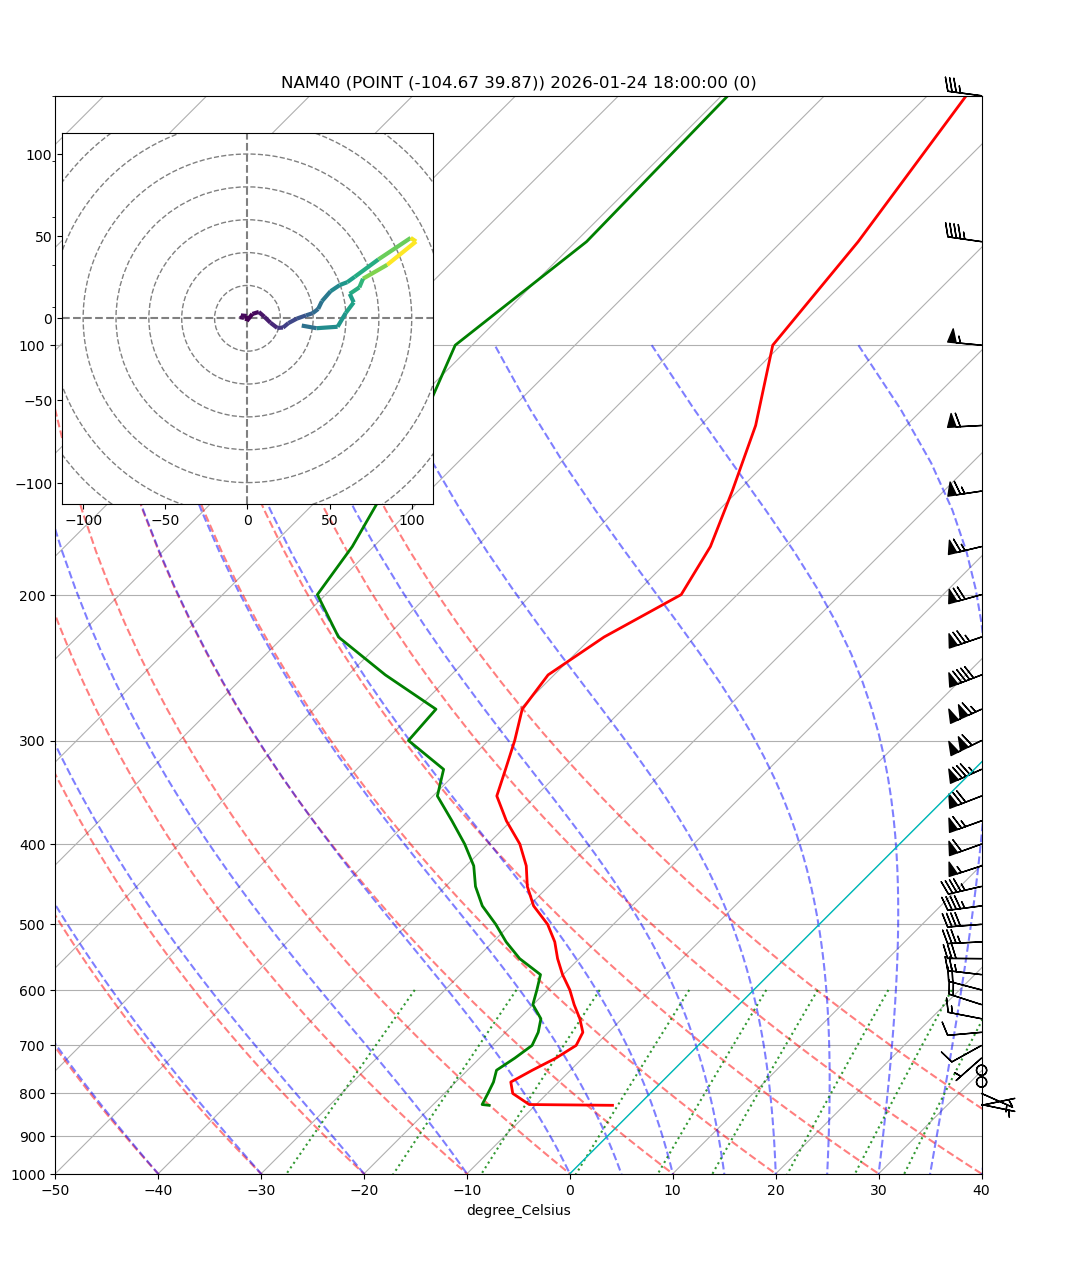

In [8]:
plot_skewT(model, p, t, d, u, v, w, timeRange[0])

<a href="#top">Top</a>

---

## Model Sounding Comparison

Now that we know how to retreive and plot the data for one model, we can run a loop to retreive data for various models and plot them for comparison.  In this example we'll also plot RAP13 and GFS20 data to compare with NAM40.

This is also where our functions become so important, because we can easily recall all that logic and keep this for-loop fairly simple.

Using RAP13 forecast time 2026-01-25 01:00:00 (0)


Found surface record at 832.9MB


Using 32 levels between 832.9 and 100.0MB


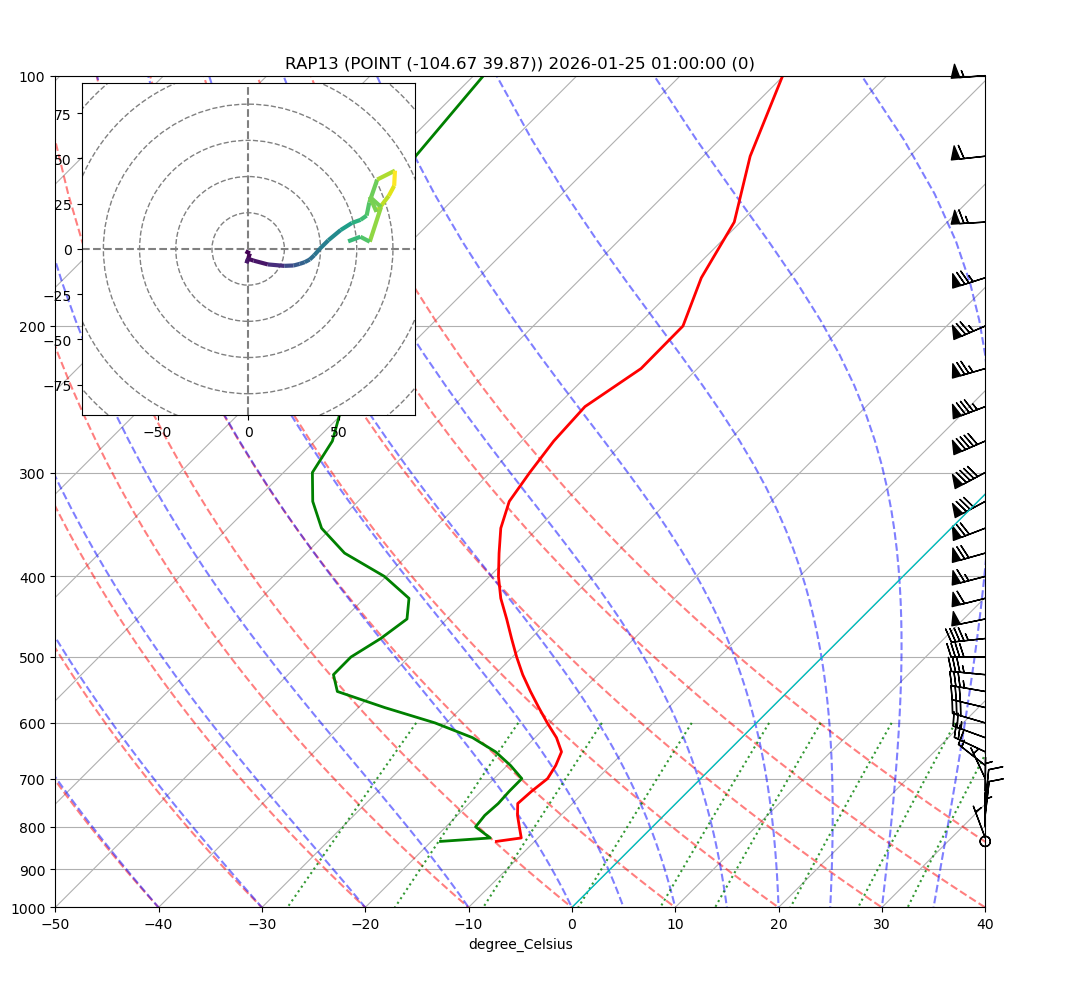

Using GFS20 forecast time 2026-01-24 18:00:00 (0)
Found surface record at 837.3MB


Using 32 levels between 837.3 and 100.0MB


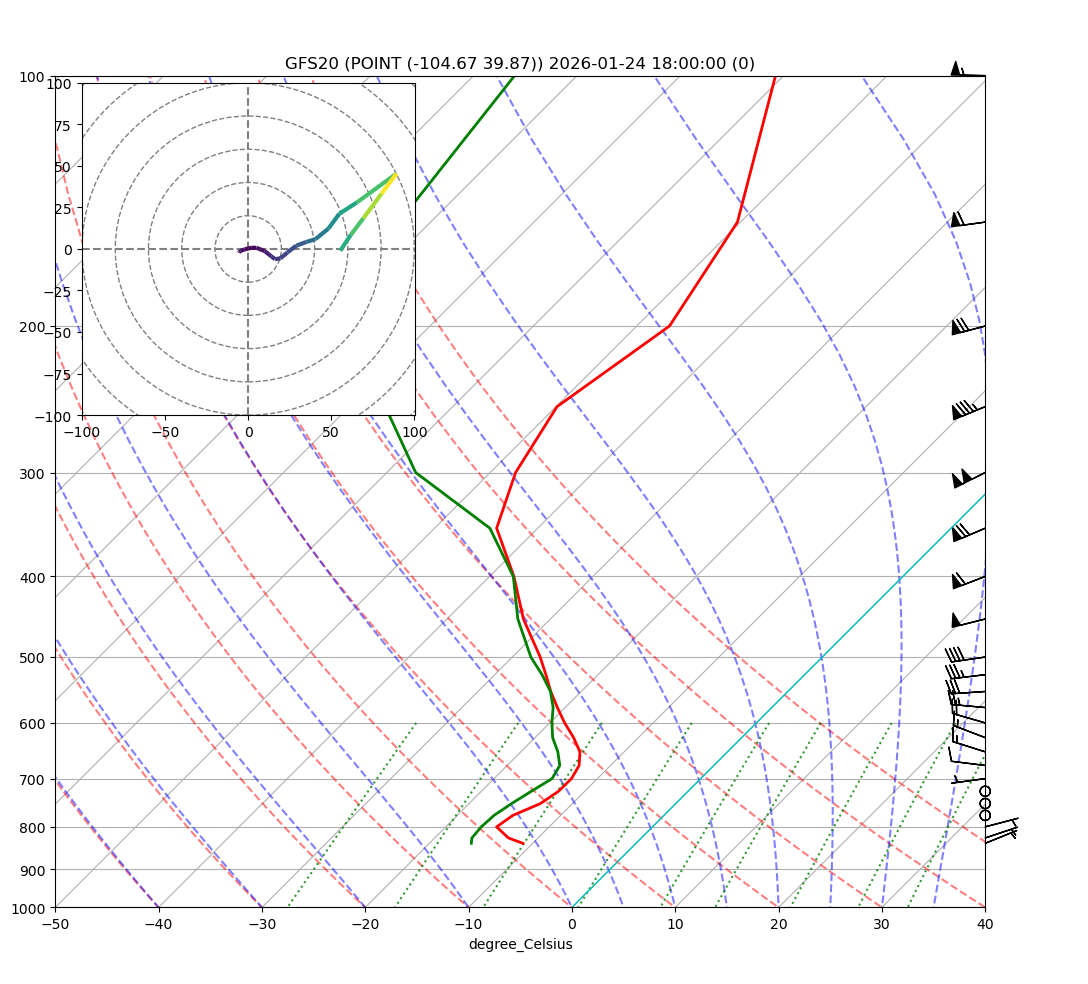

Using NAM40 forecast time 2026-01-25 00:00:00 (0)
Found surface record at 826.0MB


Using 32 levels between 826.0 and 50.0MB


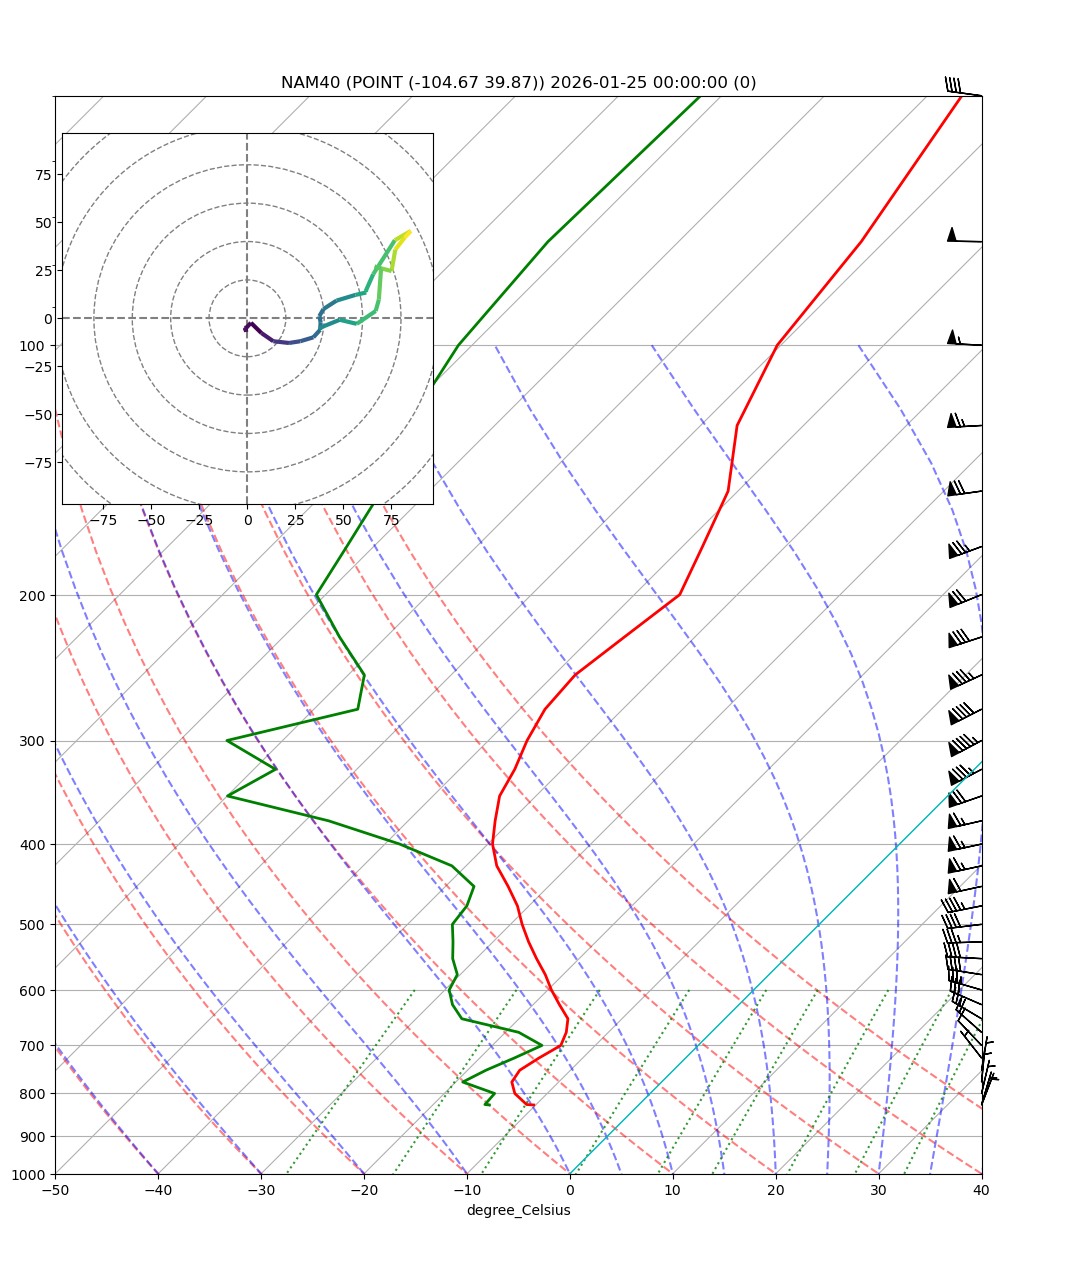

In [9]:
models = ["RAP13", "GFS20", "NAM40"]

for modelName in models:
    timeReq = DataAccessLayer.newDataRequest("grid")
    timeReq.setLocationNames(modelName)
    cycles = DataAccessLayer.getAvailableTimes(timeReq, True)
    times = DataAccessLayer.getAvailableTimes(timeReq)
    fr = DataAccessLayer.getForecastRun(cycles[-1], times)
    print("Using " + modelName + " forecast time " + str(fr[0]))
    tr = [fr[0]]
    
    p,t,d,u,v = get_surface_data(modelName,point,tr)
    p,t,d,u,v,w = get_levels_data(modelName,point,tr,p,t,d,u,v)
    
    # Skew-T
    plot_skewT(modelName,p,t,d,u,v,w,tr[0])

<a href="#top">Top</a>

---

## See Also

### Related Notebooks

* [Grid Levels and Parameters](https://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)
* [Upper Air BUFR Soundings](http://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)
* [Model Sounding Data](http://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)

### Additional Documentation

**python-awips:**

* [awips.DataAccessLayer](http://unidata.github.io/python-awips/api/DataAccessLayer.html)
* [awips.ModelSounding](https://unidata.github.io/python-awips/api/ModelSounding.html)

**matplotlib:**

* [matplotlib.pyplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html)

**MetPy**

* [metpy.wind_speed](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_speed.html)
* [metpy.wind_direction](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_direction.html)
* [metpy.vapor_pressure](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.vapor_pressure.html)
* [metpy.dewpoint](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dewpoint.html)
* [metpy.skewt](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.SkewT.html)
* [metpy.hodograph](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.Hodograph.html)

<a href="#top">Top</a>

---